In [1]:
import nltk
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn import metrics
import random
random.seed(42)
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

%matplotlib inline
import matplotlib.pyplot as plt

nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data = pd.read_csv("/content/emails.csv")

In [3]:
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [4]:
data['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

In [5]:
spam_n, ham_n = len(data[data["spam"] == 1]), len(data[data["spam"] == 0])
print(f"Percentage of spam emails = {round((spam_n)/(spam_n + ham_n) * 100, 2)}%")
print(f"Percentage of ham emails = {round((ham_n)/(spam_n + ham_n) * 100, 2)}%")

Percentage of spam emails = 23.88%
Percentage of ham emails = 76.12%


In [6]:
data.shape

(5728, 2)

In [7]:
print(data.describe())

              spam
count  5728.000000
mean      0.238827
std       0.426404
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000


In [8]:
c = 0

regex = f"^Subject:\s"
for i in range(data.shape[0]):
    match = re.search(regex, data.iloc[i, 0])
    if match:
        c = c + 1
if c == data.shape[0]:
    print("All messages have the form 'Subject: <text>'")
else:
    print("The form breaks somewhere")

All messages have the form 'Subject: <text>'


In [9]:
def preprocess_text(text):
    text = text.lower()
    regex = f"^subject:\s(.*)"
    match = re.search(regex, text)
    if match:
      text = match.group(1)
    text = re.sub(r"[^a-z .]", "", text)
    words = text.split()
    words = [word for word in words if word.isalpha() and word not in stopwords.words('english')]
    return ' '.join(words)


print("Begin text preprocessing:", end="\n\n")
data["processed_text"] = ""
for i in range(data.shape[0]):
    if i % 500 == 0 and i != 0:
        a = round(i/data.shape[0]*100)
        print("+"*(a//10*4) + "-"*(40-(a//10*4)) + " : "+ str(a) + "% completed")
    data["processed_text"][i] = preprocess_text(data["text"][i])
    if i == data.shape[0]-1:
        print("+"*40 + " : " + "100% completed", end="\n\n")
print("Preprocessing complete")

Begin text preprocessing:

---------------------------------------- : 9% completed
++++------------------------------------ : 17% completed
++++++++-------------------------------- : 26% completed
++++++++++++---------------------------- : 35% completed
++++++++++++++++------------------------ : 44% completed
++++++++++++++++++++-------------------- : 52% completed
++++++++++++++++++++++++---------------- : 61% completed
++++++++++++++++++++++++++++------------ : 70% completed
++++++++++++++++++++++++++++------------ : 79% completed
++++++++++++++++++++++++++++++++-------- : 87% completed
++++++++++++++++++++++++++++++++++++---- : 96% completed
++++++++++++++++++++++++++++++++++++++++ : 100% completed

Preprocessing complete


In [10]:
data.head(10)

,text,spam,processed_text
0,Subject: naturally irresistible your corporate...,1,naturally irresistible corporate identity lt r...
1,Subject: the stock trading gunslinger fanny i...,1,stock trading gunslinger fanny merrill muzo co...
2,Subject: unbelievable new homes made easy im ...,1,unbelievable new homes made easy im wanting sh...
3,Subject: 4 color printing special request add...,1,color printing special request additional info...
4,"Subject: do not have money , get software cds ...",1,money get software cds software compatibility ...
5,"Subject: great nnews hello , welcome to medzo...",1,great nnews hello welcome medzonline sh ground...
6,Subject: here ' s a hot play in motion homela...,1,hot play motion homeland security investments ...
7,Subject: save your money buy getting this thin...,1,save money buy getting thing tried cialls yet ...
8,Subject: undeliverable : home based business f...,1,undeliverable home based business grownups mes...
9,Subject: save your money buy getting this thin...,1,save money buy getting thing tried cialls yet ...


In [11]:
# Breaking the dataset into 70%, 15%, 15% for train, validation and test respectively
X_train, X_val_test, y_train, y_val_test = train_test_split(data["processed_text"], data["spam"], test_size = 0.30, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.50, random_state = 42)

In [12]:
len(X_train), len(X_val)

(4009, 859)

In [13]:
len(pd.concat([X_train, X_val], axis = 0))

4868

#### Some predefined functions

In [60]:
def f1_score(predictions, y_test):
    predictions = np.array(predictions)
    y_test = np.array(y_test)
    TP = np.sum((predictions == 1)[y_test==1])
    FP = np.sum((predictions == 1)[y_test == 0])
    FN = np.sum((predictions == 0)[y_test==1])
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    if precision == 0 and recall == 0:
        return 0
    f1 = 2 * precision * recall/(precision + recall)
    return f1

def precision(predictions, y_test):
    predictions = np.array(predictions)
    y_test = np.array(y_test)
    TP = np.sum((predictions == 1)[y_test==1])
    FP = np.sum((predictions == 1)[y_test == 0])
    precision = TP/(TP + FP)
    return precision

def recall(predictions, y_test):
    predictions = np.array(predictions)
    y_test = np.array(y_test)
    TP = np.sum((predictions == 1)[y_test==1])
    FN = np.sum((predictions == 0)[y_test == 1])
    recall = TP/(TP+FN)
    return recall

def accuracy(predictions, y_test):
    predictions = np.array(predictions)
    y_test = np.array(y_test)
    TP = np.sum((predictions == 1)[y_test==1])
    TN = np.sum((predictions == 0)[y_test==0])
    accuracy = (TP + TN)/len(y_test)
    return accuracy

def plot_confusion_matrix(predictions, y_val):
    # Creating the confusion matrix
    matrix = confusion_matrix(predictions, y_val)

    # Creating a heatmap using seaborn
    sns.set(font_scale=1.0)
    fig, ax = plt.subplots(figsize=(5, 3))
    ax = sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False,
                     xticklabels=['Actual Negative', 'Actual Positive'],
                     yticklabels=['Predicted Negative', 'Predicted Positive'])

    plt.title('Confusion Matrix')
    plt.show();

# Naive Bayes

In [15]:
pipeline_nb = make_pipeline(CountVectorizer(), MultinomialNB())
pipeline_nb.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [16]:
# Make predictions on the validation set
predictions = pipeline_nb.predict(X_val)

In [17]:
# Evaluate the model
accuracy = np.sum(np.array(y_val) == predictions)/y_val.shape[0]
print("Accuracy : " + str(round(accuracy * 100, 2)))
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

Accuracy : 98.84
Precision : 98.57%
Recall : 96.73%
f1 score : 97.64%


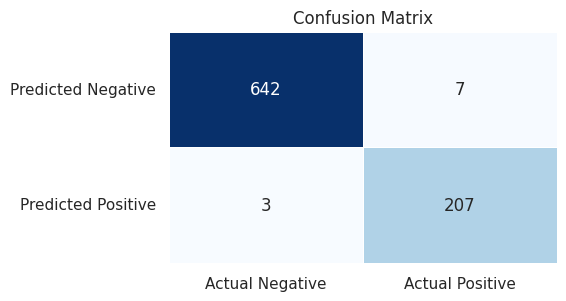

In [18]:
# Display classification report
plot_confusion_matrix(predictions, y_val)

# Logistic Regression

In [19]:
pipeline_lr = make_pipeline(CountVectorizer(), LogisticRegression(random_state = 42))
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('logisticregression', LogisticRegression(random_state=42))])

In [20]:
# Make predictions on the validation set
predictions = pipeline_lr.predict(X_val)

In [21]:
# Evaluate the model
accuracy = np.sum(np.array(y_val) == predictions)/y_val.shape[0]
print("Accuracy : " + str(round(accuracy * 100, 2)))
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

Accuracy : 98.49
Precision : 97.63%
Recall : 96.26%
f1 score : 96.94%


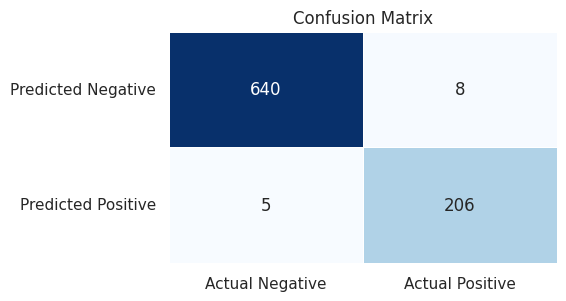

In [22]:
# Display Confusion Matrix
plot_confusion_matrix(predictions, y_val)

# Random Forest Classifier

In [23]:
pipeline = make_pipeline(CountVectorizer(), RandomForestClassifier(random_state = 42, max_depth = 100))
pipeline.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=100, random_state=42))])

In [24]:
# Make predictions on the validation set
predictions = pipeline.predict(X_val)

In [25]:
# Evaluate the model
accuracy = np.sum(np.array(y_val) == predictions)/y_val.shape[0]
print("Accuracy : " + str(round(accuracy * 100, 2)))
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

Accuracy : 96.74
Precision : 100.0%
Recall : 86.92%
f1 score : 93.0%


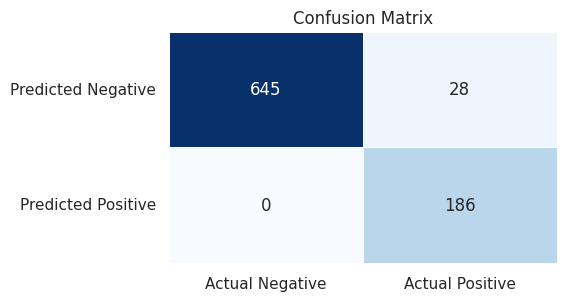

In [26]:
# Display Confusion Matrix
plot_confusion_matrix(predictions, y_val)

Now, a Grid Search on maximum depth for Random Forest

In [27]:
params = {"max_depth": [i for i in range(80, 121)]}

grcv = GridSearchCV(estimator = RandomForestClassifier(random_state=42, n_jobs=-1),
                    param_grid = params, scoring = f1_score, n_jobs=-1,
                    cv = 5, verbose=3)
pipeline = make_pipeline(CountVectorizer(), grcv)
pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 41 candidates, totalling 205 fits


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(n_jobs=-1,
                                                               random_state=42),
                              n_jobs=-1,
                              param_grid={'max_depth': [80, 81, 82, 83, 84, 85,
                                                        86, 87, 88, 89, 90, 91,
                                                        92, 93, 94, 95, 96, 97,
                                                        98, 99, 100, 101, 102,
                                                        103, 104, 105, 106, 107,
                                                        108, 109, ...]},
                              scoring=<function f1_score at 0x7a3713a1a050>,
                              verbose=3))])

In [28]:
pipeline[1].best_params_

{'max_depth': 80}

In [29]:
pipeline_rf = make_pipeline(CountVectorizer(), RandomForestClassifier(random_state = 42, max_depth=80, n_jobs=-1))
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=80, n_jobs=-1,
                                        random_state=42))])

In [30]:
# Make predictions on the validation set
predictions = pipeline_rf.predict(X_val)

In [31]:
# Evaluate the model
accuracy = np.sum(np.array(y_val) == predictions)/y_val.shape[0]
print("Accuracy : " + str(round(accuracy * 100, 2)))
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

Accuracy : 96.86
Precision : 99.47%
Recall : 87.85%
f1 score : 93.3%


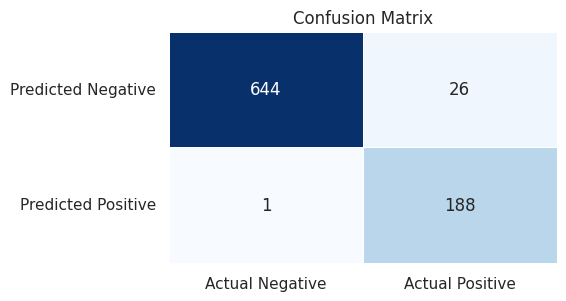

In [32]:
# Display Confusion Matrix
plot_confusion_matrix(predictions, y_val)

# XGBoost

In [33]:
pipeline = make_pipeline(CountVectorizer(), XGBClassifier())
pipeline.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [34]:
# Make predictions on the validation set
predictions = pipeline.predict(X_val)

In [35]:
# Evaluate the model
accuracy = np.sum(np.array(y_val) == predictions)/y_val.shape[0]
print("Accuracy : " + str(round(accuracy * 100, 2)))
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

Accuracy : 98.02
Precision : 96.24%
Recall : 95.79%
f1 score : 96.02%


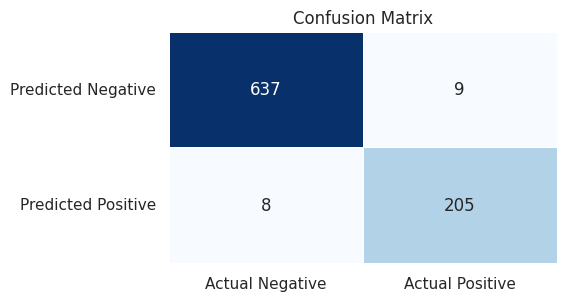

In [36]:
# Display Confusion Matrix
plot_confusion_matrix(predictions, y_val)

In [37]:
params = {"eta" : [0.1*i for i in range(1, 6)], "gamma": [i for i in range(0, 11)]}

grcv = GridSearchCV(estimator = XGBClassifier(), param_grid = params,
                    scoring = f1_score, n_jobs=-1,
                    cv = 5, verbose=3)
pipeline = make_pipeline(CountVectorizer(), grcv)
pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('gridsearchcv',
                 GridSearchCV(cv=5,
                              estimator=XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'eta': [0.1, 0.2, 0.30000000000000004,
                                                  0.4, 0.5],
                                          'gamma': [0, 1, 2, 3, 4, 5, 6, 7, 8,
                                                    9, 10]},
                              scoring=<function f1_score at 0x7a3713a1a050>,
                              verbose=3))])

In [38]:
pipeline[1].best_params_

{'eta': 0.1, 'gamma': 0}

In [39]:
pipeline_xgb = make_pipeline(CountVectorizer(), XGBClassifier(gamma=0, eta=0.1))
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.1,
                               eval_metric=None, feature_types=None, gamma=0,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [40]:
# Make predictions on the validation set
predictions = pipeline_xgb.predict(X_val)

In [41]:
# Evaluate the model
accuracy = np.sum(np.array(y_val) == predictions)/y_val.shape[0]
print("Accuracy : " + str(round(accuracy * 100, 2)))
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

Accuracy : 98.6
Precision : 96.76%
Recall : 97.66%
f1 score : 97.21%


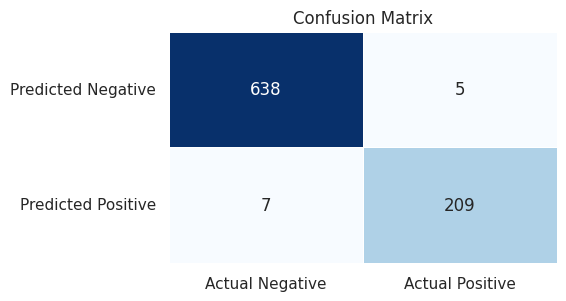

In [42]:
plot_confusion_matrix(predictions, y_val)

# SVM

In [43]:
pipeline = make_pipeline(CountVectorizer(), SVC(random_state = 42))
pipeline.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('svc', SVC(random_state=42))])

In [44]:
# Make predictions on the validation set
predictions = pipeline.predict(X_val)

In [45]:
# Evaluate the model
accuracy = np.sum(np.array(y_val) == predictions)/y_val.shape[0]
print("Accuracy : " + str(round(accuracy * 100, 2)))
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

Accuracy : 97.9
Precision : 99.0%
Recall : 92.52%
f1 score : 95.65%


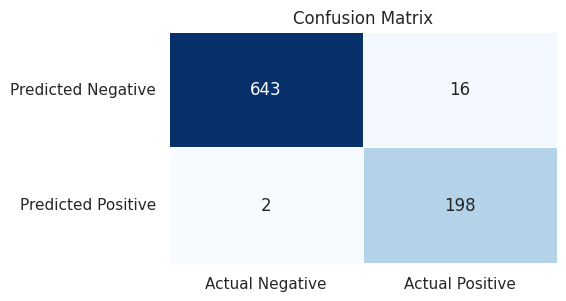

In [46]:
# Display Confusion Matrix
plot_confusion_matrix(predictions, y_val)

In [47]:
params = {"C": [1,2,3,4], "kernel" : ["linear", "poly", "rbf", "sigmoid"], "degree" : [1,2,3,4,5]}


grcv = GridSearchCV(estimator = SVC(random_state = 42), param_grid = params,
                    scoring = f1_score, n_jobs=-1,
                    cv = 5, verbose=3)
pipeline = make_pipeline(CountVectorizer(), grcv)
pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('gridsearchcv',
                 GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
                              param_grid={'C': [1, 2, 3, 4],
                                          'degree': [1, 2, 3, 4, 5],
                                          'kernel': ['linear', 'poly', 'rbf',
                                                     'sigmoid']},
                              scoring=<function f1_score at 0x7a3713a1a050>,
                              verbose=3))])

In [48]:
pipeline[1].best_params_

{'C': 1, 'degree': 1, 'kernel': 'linear'}

In [49]:
pipeline_svm = make_pipeline(CountVectorizer(), SVC(C=1, kernel="linear", random_state = 42, degree = 1))
pipeline_svm.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('svc', SVC(C=1, degree=1, kernel='linear', random_state=42))])

In [50]:
# Make predictions on the validation set
predictions = pipeline_svm.predict(X_val)

In [51]:
# Evaluate the model
accuracy = np.sum(np.array(y_val) == predictions)/y_val.shape[0]
print("Accuracy : " + str(round(accuracy * 100, 2)))
print("Precision : " + str(round(precision(predictions, y_val)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_val)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_val)*100, 2)) + "%")

Accuracy : 97.56
Precision : 96.62%
Recall : 93.46%
f1 score : 95.01%


The f1 score has decreased even after grid search hyperparameter tuning.
Let's see the predictions on the training set itself

In [52]:
# Make predictions on the training set itself
predictions = pipeline_svm.predict(X_train)

# Evaluate the model
accuracy = np.sum(np.array(y_train) == predictions)/y_train.shape[0]
print("Accuracy : " + str(round(accuracy * 100, 2)))
print("Precision : " + str(round(precision(predictions, y_train)*100, 2)) + "%")
print("Recall : " + str(round(recall(predictions, y_train)*100, 2)) + "%")
print("f1 score : " + str(round(f1_score(predictions, y_train)*100, 2)) + "%")

Accuracy : 100.0
Precision : 100.0%
Recall : 100.0%
f1 score : 100.0%


This is the case of overfitting. The model is performing perfectly on the training set.

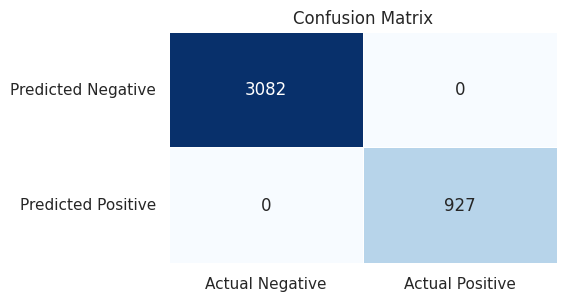

In [53]:
# Display Confusion Matrix
plot_confusion_matrix(predictions, y_train)

In [54]:
models = [pipeline_nb, pipeline_lr, pipeline_rf, pipeline_xgb, pipeline_svm]

In [62]:
df = pd.DataFrame(np.zeros((5, 4)))
df.index = ["Naive Bayes", "Logistic Regression", "Random Forest", "XGBoost", "Support Vactor Classifier"]
df.columns = ["Accuracy", "Precision", "Recall", "f1 score"]


for i in range(5):
    model = models[i]
    predictions = model.predict(X_test)
    df.iloc[i,0] = str(round(accuracy(predictions, y_test)*100, 2)) + "%"
    df.iloc[i,1] = str(round(precision(predictions, y_test)*100, 2)) + "%"
    df.iloc[i,2] = str(round(recall(predictions, y_test)*100, 2)) + "%"
    df.iloc[i,3] = str(round(f1_score(predictions, y_test)*100, 2)) + "%"

print(df)

                          Accuracy Precision  Recall f1 score
Naive Bayes                 98.72%    96.96%  98.24%   97.59%
Logistic Regression         99.07%     99.1%  97.36%   98.22%
Random Forest               96.05%    100.0%  85.02%    91.9%
XGBoost                     98.14%    95.28%   97.8%   96.52%
Support Vactor Classifier   97.79%    95.61%  96.04%   95.82%
